In [3]:
import matplotlib.pyplot as plt

import numpy as np
import copy
from datetime import datetime


class Function(object):
    f = None
    a = None
    b = None

    @staticmethod
    def set_func(func):
        Function.f = func
        Function.a, Function.b = {
            Function.sphere: (-5.12, 5.12),
            Function.rastrigin: (-5.12, 5.12),
            Function.rosenbrock: (-2.048, 2.048),
            Function.ackley: (-32, 32),
            Function.sn: (-1.02, 1.02),
            Function.sn2: (-1.05, 1.05),
            Function.sn3: (-0.3, 0.3)
        }.get(func, None)

    @staticmethod
    def sphere(arg_vec):
        return np.sum([x ** 2 for x in arg_vec])

    @staticmethod
    def rosenbrock(arg_vec):
        return sum([(100 * (xj - xi ** 2) ** 2 + (xi - 1) ** 2) for xi, xj in zip(arg_vec[:-1], arg_vec[1:])])

    @staticmethod
    def rastrigin(arg_vec):
        return 10 * len(arg_vec) + np.sum([x ** 2 - 10 * np.cos(2 * np.pi * x) for x in arg_vec])

    @staticmethod
    def ackley(arg_vec):
        s1 = -0.2 * np.sqrt(np.sum([x ** 2 for x in arg_vec]) / len(arg_vec))
        s2 = np.sum([np.cos(2 * np.pi * x) for x in arg_vec]) / len(arg_vec)
        return 20 + np.e - 20 * np.exp(s1) - np.exp(s2)

    @staticmethod
    def sn(arg_vec):
        s1 = (sum(arg_vec) - sum(x*x for x in arg_vec)) * sum(np.cos(x) for x in arg_vec)
        s2 = 4 / (np.sqrt(np.abs(np.tan(sum(arg_vec))))) + int(sum(x*x for x in arg_vec))
        return s1 / s2

    @staticmethod
    def sn2(arg_vec):
        s1 =  arg_vec[0] * np.cos(arg_vec[1])
        s2 = (arg_vec[0] ** 2 - arg_vec[1] + 1) - (1 - arg_vec[1] ** 2)
        return s1 / s2

    @staticmethod
    def sn3(arg_vec):
        s1 =  arg_vec[0] * np.cos(arg_vec[1])
        s2 = arg_vec[1] * (1 - arg_vec[0]) ** 2 + 2 * (1 + arg_vec[1])
        return s1 / s2


class MA(object):
    def __init__(self,
                population_size,
                fitness_vector_size,
                bits_per_param,
                generations,
                prob_crossover,
                prob_mutation,
                prob_local,
                max_local_gens):
        self.population_size = population_size
        self.fitness_vector_size = fitness_vector_size
        self.bits_per_param = bits_per_param
        self.generations = generations
        self.prob_crossover = prob_crossover
        self.prob_mutation = prob_mutation
        self.prob_local = prob_local
        self.max_local_gens = max_local_gens
        self.population = None
        self.best = None

    def float_rand(self, a, b, size=None):
        return a + ((b - a) * np.random.random(size))

    def generate_population(self):
        self.population = [Individual(self.random_bitstring()) for _ in range(self.population_size)]
        self.best = sorted(self.population, key=lambda x: x.fitness)[0]

    def random_bitstring(self):
        return ''.join(np.random.choice(['0', '1'], self.fitness_vector_size * self.bits_per_param))

    def binary_tournament(self):
        pair_size = 2
        new_popul = [np.random.choice(self.population, pair_size, replace=False) for _ in range(self.population_size)]
        return np.array([min(y, key=lambda x: x.fitness) for y in new_popul])

    def point_mutation(self, bitstring):
        bitstring = list(bitstring)
        for i in range(len(bitstring)):
            if np.random.random() < self.prob_mutation:
                bitstring[i] = '1' if bitstring[i] == '0' else '0'
        return ''.join(bitstring)

    def crossover(self, parent1, parent2):
        if np.random.random() >= self.prob_crossover:
            return parent1.bitstring
        return ''.join([a if np.random.random() < self.prob_crossover
                        else b for a, b in zip(parent1.bitstring, parent2.bitstring)])

    def reproduce(self, selected):
        children = []
        for a, b in zip(selected[::2], selected[1::2]):
            children.append(Individual(self.point_mutation(self.crossover(a, b))))
            children.append(Individual(self.point_mutation(self.crossover(b, a))))
        return children

    def bitclimber(self, child):
        current = copy.copy(child)
        for _ in range(self.max_local_gens):
            candidate = Individual(self.point_mutation(current.bitstring))
            current = candidate if candidate.fitness <= current.fitness else current
        return current

    def run(self):
        self.generate_population()
        for gen in range(self.generations):
            selected = self.binary_tournament()
            children = self.reproduce(selected)
            del self.population[:]
            for child in children:
                if np.random.random() < self.prob_local:
                    child = self.bitclimber(child)
                self.population.append(child)
            self.population = sorted(self.population, key=lambda x: x.fitness)
            self.best = self.population[0] if self.population[0].fitness <= self.best.fitness else self.best
            # if gen % 50 == 0:
            #     print('{0}/{1} Current population:'.format(gen, self.generations))
            #     print(self.best)


class Individual(object):
    def __init__(self, bitstring):
        self.bitstring = bitstring  # phenotype
        nums = [int(bitstring[i:i + bits_per_param], 2) for i in range(0, len(bitstring), bits_per_param)]
        self.vector = [Function.a + ((Function.b - Function.a) / ((2.0 ** bits_per_param) - 1.0)) * x for x in nums]
        self.fitness = Function.f(self.vector)  # value of the fitness function

    def __str__(self):
        return '{0} = {1}'.format(self.vector, self.fitness)

# dim = 2
bits_per_param = 32
# max_gens = 500
# pop_size = 200
p_cross = 0.98
p_local = 0.5
# p_mut = 1.0 / (dim * bits_per_param)
max_local_gens = 30

Function.set_func(Function.ackley)


def main():
    array = []
    i = 1
    for pop_size in [10, 100, 200, 300]:
        for max_gens, dim in zip([100, 200, 300], [2, 3, 5]):
            p_mut = 1.0 / (dim * bits_per_param)
            start_time = datetime.now()
            mem = MA(pop_size,
                    dim,
                    bits_per_param,
                    max_gens,
                    p_cross,
                    p_mut,
                    p_local,
                    max_local_gens)
            mem.run()
            fin_time = datetime.now()
            print("dim | pop_size | max_gens | mem.best.fitness | time_taken_to_finish")
            print('{0} | {1} | {2} | {3} | {4}'.format(dim, pop_size, max_gens, mem.best.fitness, fin_time - start_time))
            array.append([i, mem.best.fitness])


if __name__ == '__main__':
    main()


2;10;100;1.0745383871579861e-07;0:00:00.797743
3;10;200;2.980232505223057e-08;0:00:02.060211
5;10;300;5.122194810525116e-07;0:00:04.351215
2;100;100;2.980232460814136e-08;0:00:08.987549
3;100;200;2.980232505223057e-08;0:00:22.334166
5;100;300;4.8054808132746984e-08;0:00:48.263280
2;200;100;2.980232460814136e-08;0:00:20.759077
3;200;200;2.980232505223057e-08;0:00:49.802837
5;200;300;2.980232460814136e-08;0:01:44.633038
2;300;100;2.980232460814136e-08;0:00:35.746524
3;300;200;2.980232505223057e-08;0:01:22.486465
5;300;300;2.980232460814136e-08;0:02:42.186281


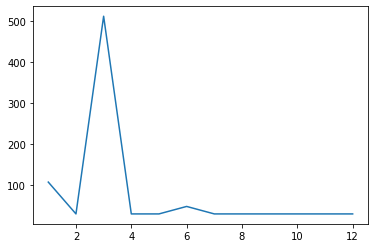

In [7]:
array = [
            1.0745383871579861e-07,
            2.980232505223057e-08,
            5.122194810525116e-07,
            2.980232460814136e-08,
            2.980232505223057e-08,
            4.8054808132746984e-08,
            2.980232460814136e-08,
            2.980232505223057e-08,
            2.980232460814136e-08,
            2.980232460814136e-08,
            2.980232505223057e-08,
            2.980232460814136e-08
        ]

a = [i for i in range(1,len(array)+1)]
b = [i*(10**9) for i in array]

plt.plot(a,b)